## CNN Architecture

The CNN is defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

We use the above layers and add multiple convolutional layers and things like dropout layers that may prevent overfitting. 

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!rm -r /data/
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2020-04-16 21:45:01--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.36.246
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.36.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  65.6MB/s    in 5.4s    

2020-04-16 21:45:06 (60.1 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_10

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [43]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=512, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=256, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. 

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors


In [45]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [46]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. 

#### Batch size
Decide on a good batch size for training your model. We try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause our model to crash and/or run out of memory while training.


In [47]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

We take a look at how this model performs before it trains. We see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that we can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how our model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [48]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [49]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, we have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [144]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        print (images.shape)
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [51]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [52]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that we applied these transformations when we loaded our test data.

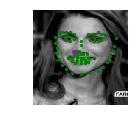

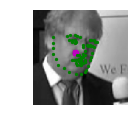

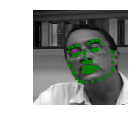

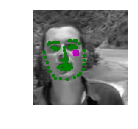

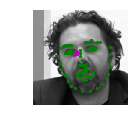

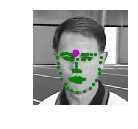

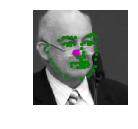

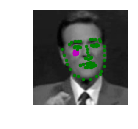

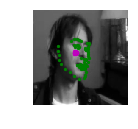

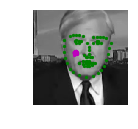

In [53]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, we may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. 

Next, we'll define how the model will train by deciding on the loss function and optimizer.

---

In [54]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)


## Training and Initial Observation

Now, we'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how our model is training and decide on whether or not we should modify it's structure or hyperparameters, we start off with just one or two epochs at first. 

We use these initial observations to make changes to our model and decide on the best architecture before we train for many epochs and create a final model.

In [55]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            #key_pts = key_pts.type(torch.DoubleTensor)
            #images = images.type(torch.DoubleTensor)
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [56]:
# train your network
n_epochs = 1 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.6115720689296722
Epoch: 1, Batch: 20, Avg. Loss: 0.663473641872406
Epoch: 1, Batch: 30, Avg. Loss: 0.5979970902204513
Epoch: 1, Batch: 40, Avg. Loss: 0.5254956543445587
Epoch: 1, Batch: 50, Avg. Loss: 0.5240291208028793
Epoch: 1, Batch: 60, Avg. Loss: 0.4878267258405685
Epoch: 1, Batch: 70, Avg. Loss: 0.3835452765226364
Epoch: 1, Batch: 80, Avg. Loss: 0.41922593414783477
Epoch: 1, Batch: 90, Avg. Loss: 0.3616964131593704
Epoch: 1, Batch: 100, Avg. Loss: 0.36885815262794497
Epoch: 1, Batch: 110, Avg. Loss: 0.27233653515577316
Epoch: 1, Batch: 120, Avg. Loss: 0.26899505853652955
Epoch: 1, Batch: 130, Avg. Loss: 0.2625533252954483
Epoch: 1, Batch: 140, Avg. Loss: 0.29717699587345126
Epoch: 1, Batch: 150, Avg. Loss: 0.2324319750070572
Epoch: 1, Batch: 160, Avg. Loss: 0.2744138941168785
Epoch: 1, Batch: 170, Avg. Loss: 0.24218292832374572
Epoch: 1, Batch: 180, Avg. Loss: 0.18970709890127183
Epoch: 1, Batch: 190, Avg. Loss: 0.20952862203121186
Epoch: 1, Batc

## Test data

See how our model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, we run our trained model on these images to see what kind of keypoints are produced. 

In [145]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


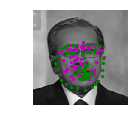

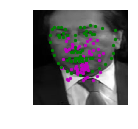

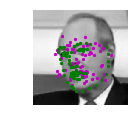

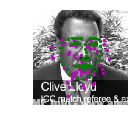

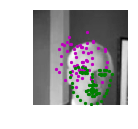

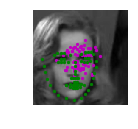

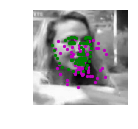

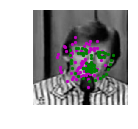

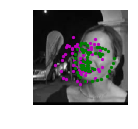

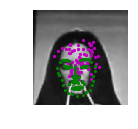

In [58]:
## visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once we've found a good model (or two), we save our model so we can load it and use it later!


In [143]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and we can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, we can see how to extract a single filter (by index) from our first convolutional layer. The filter should appear as a grayscale grid.

[[-0.17114028  0.11365734 -0.06634498 -0.03771101  0.10105544]
 [-0.02270353  0.03301235 -0.05490753  0.16379261 -0.02290273]
 [-0.19752097  0.06159482 -0.05905002  0.01130442 -0.1177962 ]
 [-0.17716095  0.05367972 -0.00968626  0.13770947 -0.04906782]
 [-0.07494322  0.16837892  0.11521756 -0.04146283 -0.17300099]]
(5, 5)


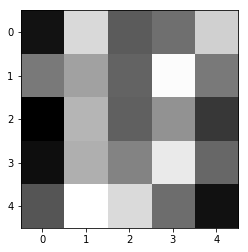

In [138]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 2

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, we might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. we can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, we might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, we choose a test image and filter it with one of the convolutional kernels in our trained CNN; we look at the filtered output to get an idea what that particular kernel detects.



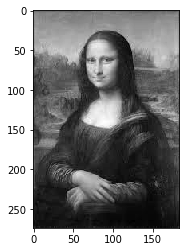

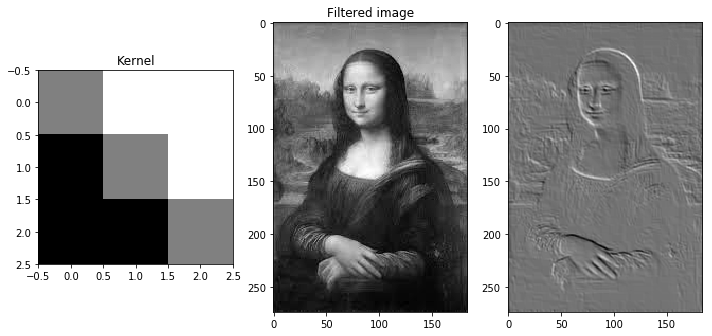

In [141]:
image = mpimg.imread('images/mona_lisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.
plt.imshow(image, cmap='gray');
filter_kernel = np.array([
    [ 0,  1,  1],
    [-1,  0,  1],
    [-1, -1,  0],
])

filtered_image = cv2.filter2D(image, -1, filter_kernel)

f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))
ax1.imshow(filter_kernel, cmap='gray')
ax2.imshow(image, cmap='gray')
ax3.imshow(filtered_image, cmap='gray')

ax1.set_title('Kernel')
ax2.set_title('Test image')
ax2.set_title('Filtered image')
plt.tight_layout();


We Choose one filter from our trained CNN and apply it to a test image.


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
[[ 0.03818378 -0.06698184  0.00609102 -0.07083632  0.01827245]
 [-0.06721092 -0.16550259  0.16420917  0.19742732 -0.02312281]
 [ 0.16293016 -0.15960392 -0.00638123 -0.13050044  0.14354965]
 [-0.11457523 -0.16175282  0.13631357  0.17652564 -0.19335625]
 [-0.19882376 -0.05630763 -0.01270404 -0.14749154 -0.09688754]]


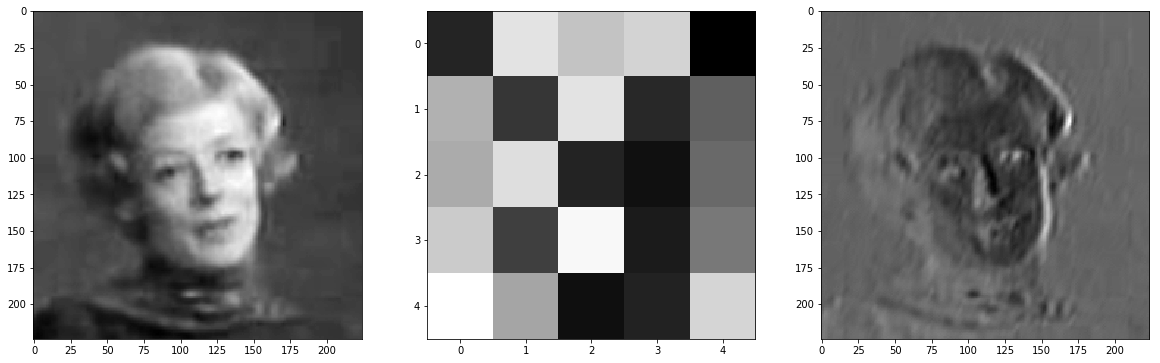

In [142]:
import cv2
import matplotlib.image as mpimg
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
image_Tensor = test_images[1][0]
image = np.array(image_Tensor)

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
weights1 = net.conv1.weight.data
filter_index = 10
w = weights1.numpy()
filter_kernel = w[filter_index][0]
image_filtered = cv2.filter2D(image, -1, filter_kernel)

print(filters)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,10))
ax1.imshow(image, cmap='gray')
ax2.imshow(filter_kernel, cmap='gray')
ax3.imshow(image_filtered, cmap='gray')

As we can see, this kernel emphasizes horizontal edges. In general it is safe to assume that any "random enough" kernel acts as an edge detector since uniformly sampled weights will react strongly to any intensity change. This kernel doesn't look like it's particularly well developed (it shows no clear pattern), but the outcome is easy to interpret.